In [153]:
from treehopper.api import *
from treehopper.libraries.sensors.inertial import Bno055, Mpu9250
import numpy as np
from time import sleep
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

In [2]:
board = find_boards()[0]
board.connect()

In [3]:
imu = Bno055.probe(board.i2c)[0]

In [7]:
print(imu.accelerometer)

[-0.3125, 58.8125, -2.1875]


In [8]:
imu2 = Mpu9250.probe(board.i2c)[0]

In [10]:
imu2.accelerometer

[1.03271484375, 0.025634765625, 0.0660400390625]

In [11]:
imu.auto_update_when_property_read = False
imu2.auto_update_when_property_read = False

In [141]:
imu_data = np.zeros((1000, 22))  # accel + gyro + mag xyz (9) + eular (3) + quaternion (4) + gravity (3) + linear_accel (3) = 22
imu2_data = np.zeros((1000, 9))  # accel + gyro + mag xyz (9)

In [142]:
for i in range(1000):
    imu.update()
    imu2.update()
    
    imu_data[i, 0] = imu.accelerometer[0]
    imu_data[i, 1] = imu.accelerometer[1]
    imu_data[i, 2] = imu.accelerometer[2]
    
    imu_data[i, 3] = imu.gyroscope[0]
    imu_data[i, 4] = imu.gyroscope[1]
    imu_data[i, 5] = imu.gyroscope[2]
       
    imu_data[i, 6] = imu.magnetometer[0]
    imu_data[i, 7] = imu.magnetometer[1]
    imu_data[i, 8] = imu.magnetometer[2]
    
    imu_data[i, 9] = imu.eular_angles[0]
    imu_data[i, 10] = imu.eular_angles[1]
    imu_data[i, 11] = imu.eular_angles[2]
    
    imu_data[i, 12] = imu.quaternion[0]
    imu_data[i, 13] = imu.quaternion[1]
    imu_data[i, 14] = imu.quaternion[2]
    imu_data[i, 15] = imu.quaternion[3]
    
    imu_data[i, 16] = imu.gravity[0]
    imu_data[i, 17] = imu.gravity[1]
    imu_data[i, 18] = imu.gravity[2]
    
    imu_data[i, 19] = imu.linear_acceleration[0]
    imu_data[i, 20] = imu.linear_acceleration[1]
    imu_data[i, 21] = imu.linear_acceleration[2]
    
    imu2_data[i, 0] = imu2.accelerometer[0]
    imu2_data[i, 1] = imu2.accelerometer[1]
    imu2_data[i, 2] = imu2.accelerometer[2]
    
    imu2_data[i, 3] = imu2.gyroscope[0]
    imu2_data[i, 4] = imu2.gyroscope[1]
    imu2_data[i, 5] = imu2.gyroscope[2]
    
    imu2_data[i, 6] = imu2.gyroscope[0]
    imu2_data[i, 7] = imu2.gyroscope[1]
    imu2_data[i, 8] = imu2.gyroscope[2]
    sleep(0.01)

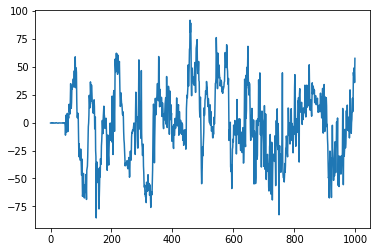

In [143]:
plot(imu_data[:, 1])

In [146]:
#scale data
max_accel = np.max(np.abs(imu_data[:, 0:3]))
max_gyro = np.max(np.abs(imu_data[:, 3:6]))
max_mag = np.max(np.abs(imu_data[:, 6:9]))
max_eular = np.max(np.abs(imu_data[:, 9:12]))
max_quaternion = np.max(np.abs(imu_data[:, 12:16]))
max_gravity = np.max(np.abs(imu_data[:, 16:19]))
max_linear = np.max(np.abs(imu_data[:, 19:]))

max_accel2 = np.max(np.abs(imu2_data[:, 0:3]))
max_gyro2 = np.max(np.abs(imu2_data[:, 3:6]))
max_mag2 = np.max(np.abs(imu2_data[:, 6:9]))

print(max_accel)
print(max_gyro)
print(max_mag)

print(max_eular)
print(max_quaternion)
print(max_gravity)
print(max_linear)

print(max_accel2)
print(max_gyro2)
print(max_mag2)

93.625
1306.625
64.0625
57.59
0.998901367188
9.8
16.66
1.79260253906
32768.0
32768.0


In [150]:
scaled_imu_data = np.copy(imu_data)
scaled_imu2_data = np.copy(imu2_data)

scaled_imu_data[:, 0:3] = scaled_imu_data[:, 0:3] / max_accel
scaled_imu_data[:, 3:6] = scaled_imu_data[:, 3:6] / max_gyro
scaled_imu_data[:, 6:9] = scaled_imu_data[:, 6:9] / max_mag

scaled_imu_data[:, 9:12] = scaled_imu_data[:, 9:12] / max_eular
scaled_imu_data[:, 12:16] = scaled_imu_data[:, 12:16] / max_quaternion
scaled_imu_data[:, 16:19] = scaled_imu_data[:, 16:19] / max_gravity
scaled_imu_data[:, 19:] = scaled_imu_data[:, 19:] / max_linear

scaled_imu2_data[:, 0:3] = scaled_imu2_data[:, 0:3] / max_accel2
scaled_imu2_data[:, 3:6] = scaled_imu2_data[:, 3:6] / max_gyro2
scaled_imu2_data[:, 6:9] = scaled_imu2_data[:, 6:9] / max_mag2

In [181]:
in_out_neurons = 9  
hidden_neurons = 50

model = Sequential()
# model.add(Dense(9, input_dim=9, activation='relu'))
model.add(SimpleRNN(input_shape=(9, ???), units=32, return_sequences=False))  
# model.add(Dense(hidden_neurons, in_out_neurons))  
model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))
model.add(Dense(22))

In [182]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [183]:
model.fit(scaled_imu2_data, scaled_imu_data, epochs=100, batch_size=100)

ValueError: Error when checking input: expected simple_rnn_8_input to have 3 dimensions, but got array with shape (1000, 9)

In [173]:
predicted = model.predict(scaled_imu2_data)

In [174]:
print(predicted.shape)

(1000, 22)


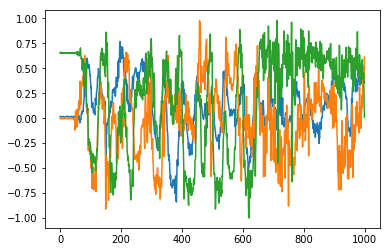

In [175]:
plot(scaled_imu_data[:, 0:3])


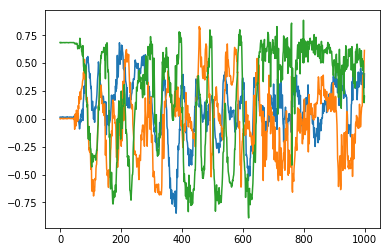

In [178]:
plot(predicted[:, 0:3])

In [122]:
%matplotlib inline
fig = Figure()
FigureCanvas(fig)
original = fig.add_subplot(111)
original.plot(imu_data[:, 0:2])
